# Build a character importance score

We want to compare for each gender the famousness, and impact of the actor.

For this we will compare the total number of votes from ImdB of the movies in which each actor played, compare the average number of votes, the average rating, and the number of movies.

In [170]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import requests
import pywikibot
import pywikibot.data.api as api

# Get data for each character

In [171]:
# Get character data from Data/MovieSummaries/character.metadata.tsv
character_data = pd.read_csv('Data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
character_data.columns = ['wiki_movie_ID','freebase_movie_ID','movie_release_date',\
    'character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity',\
        'actor_name','actor_age_movie','freebase_char/actor_map_ID','freebase_char_ID','freebase_actor_ID']

# Drop all characters without a actor_gender
character_data = character_data.drop(character_data[character_data.actor_gender.isnull()].index)

character_data

,wiki_movie_ID,freebase_movie_ID,movie_release_date,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie,freebase_char/actor_map_ID,freebase_char_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450662,913762,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd
450663,913762,/m/03pcrp,1992-05-21,Exegran,NaN,M,NaN,NaN,Hal Cleaveland,NaN,/m/0kr407c,/m/0kr406_,/m/0kr407h
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j


# Get data for each movie

In [172]:
# Open Data/Imdb/processed_imdb_dataset.csv as a dataframe
imdb_data = pd.read_csv('Data/Imdb/processed_imdb_dataset.csv', index_col=0)
imdb_data

,freebase_movie_ID,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,/m/03vyhn,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55235
1,/m/0crgdbh,tt0094806,movie,Brun bitter,Brun bitter,1988,83,"Crime,Drama",5.7,40
2,/m/01mrr1,tt0083949,movie,A Woman in Flames,Die flambierte Frau,1983,106,Drama,6.0,589
3,/m/03cfc81,tt0002894,short,The Gangsters,The Gangsters,1913,35,"Comedy,Short",6.8,16
4,/m/02qc0j7,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2159
...,...,...,...,...,...,...,...,...,...,...
46777,/m/03m6zh4,tt0109922,movie,Gopi Kishan,Gopi Kishan,1994,161,"Action,Comedy,Drama",5.8,913
46778,/m/06_vb43,tt0033660,movie,The Ghost Train,The Ghost Train,1941,85,"Comedy,Horror",6.2,1531
46779,/m/0j7hxnt,tt1816585,tvMovie,Mermaids: The Body Found,Mermaids: The Body Found,2011,82,Sci-Fi,4.6,1654
46780,/m/0g4pl34,tt1606259,movie,Knuckle,Knuckle,2011,97,"Biography,Documentary,Drama",6.8,3076


# Build a dataframe with:

- Freebase_movie_ID
- nb_character
- ratio_f_character
- rating
- votes

In [173]:
# Get all movie that appear in character_data variable
movie_list = character_data['freebase_movie_ID'].unique()

# Remove empty values from movie_list
movie_list = movie_list[~pd.isnull(movie_list)]

# Create a dataframe with all the movie ID
movie_character = pd.DataFrame({'freebase_movie_ID': movie_list})

# Merge the movie_character dataframe with the imdb_data dataframe and keep columns sum and rating
movie_character = pd.merge(movie_character, imdb_data[['freebase_movie_ID','numVotes','averageRating']], on='freebase_movie_ID', how='left')

# Drop all movies with no rating or votes
movie_character = movie_character.drop(movie_character[movie_character.numVotes.isnull()].index)
movie_character = movie_character.drop(movie_character[movie_character.averageRating.isnull()].index)

# Add column "nb_character" to movie_character with number of character per movie
character_per_movie = character_data.groupby('freebase_movie_ID').size().reset_index(name='nb_character')
movie_character = movie_character.merge(character_per_movie, on='freebase_movie_ID', how='left')

# Get number of character played by a female actor per movie
character_f_per_movie = character_data[character_data['actor_gender'] == 'F'].groupby('freebase_movie_ID').size().reset_index(name='f_character')
#character_m_per_movie = character_data[character_data['actor_gender'] == 'M'].groupby('freebase_movie_ID').size().reset_index(name='m_character')

# Add column "ratio_f_character" to movie_character with ratio of female character per movie
movie_character = movie_character.merge(character_f_per_movie, on='freebase_movie_ID', how='left')
#movie_character = movie_character.merge(character_m_per_movie, on='freebase_movie_ID', how='left')

# Change Nan values to 0
movie_character = movie_character.fillna(0)

# Add ratio column
movie_character["ratio"] = movie_character["f_character"] / movie_character["nb_character"]

# Keep 2 decimals
movie_character["ratio"] = movie_character["ratio"].round(2)

# Keep the movies in character_data that are in movie_character
character_data = character_data[character_data.freebase_movie_ID.isin(movie_character.freebase_movie_ID)]

movie_character



,freebase_movie_ID,numVotes,averageRating,nb_character,f_character,ratio
0,/m/03vyhn,55235.0,4.9,17,6.0,0.35
1,/m/0crgdbh,40.0,5.7,4,2.0,0.50
2,/m/01mrr1,589.0,6.0,3,1.0,0.33
3,/m/06yc6v,36604.0,7.2,14,8.0,0.57
4,/m/017n1p,272.0,5.4,2,1.0,0.50
...,...,...,...,...,...,...
38788,/m/04_0j2b,113.0,7.2,1,1.0,1.00
38789,/m/05zrrsp,68.0,6.0,11,5.0,0.45
38790,/m/0g9ts5h,515.0,5.0,12,5.0,0.42
38791,/m/02pygw1,101.0,5.8,2,0.0,0.00


# Clean character dataset

Remove the entries for which we do not have the movie data

Group by actor

In [174]:
character_data = character_data[character_data["freebase_movie_ID"].isin(movie_character.freebase_movie_ID)]

# Merge the character_data dataframe with the movie_character dataframe
working_data = pd.merge(character_data, movie_character, on='freebase_movie_ID', how='left')
# Drop columns that are not needed
working_data = working_data.drop(['wiki_movie_ID','movie_release_date','character_name','actor_DOB', 'actor_height', 'actor_ethnicity',\
     'actor_name', 'actor_age_movie', 'freebase_char/actor_map_ID', 'freebase_char_ID'], axis=1)

working_data


,freebase_movie_ID,actor_gender,freebase_actor_ID,numVotes,averageRating,nb_character,f_character,ratio
0,/m/03vyhn,F,/m/03wcfv7,55235.0,4.9,17,6.0,0.35
1,/m/03vyhn,F,/m/0346l4,55235.0,4.9,17,6.0,0.35
2,/m/03vyhn,M,/m/01vw26l,55235.0,4.9,17,6.0,0.35
3,/m/03vyhn,M,/m/034hyc,55235.0,4.9,17,6.0,0.35
4,/m/03vyhn,F,/m/01y9xg,55235.0,4.9,17,6.0,0.35
...,...,...,...,...,...,...,...,...
281679,/m/0g9ts5h,M,/m/0jxtsxh,515.0,5.0,12,5.0,0.42
281680,/m/0g9ts5h,F,/m/027dt0m,515.0,5.0,12,5.0,0.42
281681,/m/02pygw1,M,/m/03m6t5,101.0,5.8,2,0.0,0.00
281682,/m/02pygw1,M,/m/02qylb9,101.0,5.8,2,0.0,0.00


In [175]:
# groupby freebase_actor_ID
working_data = working_data.groupby('freebase_actor_ID').agg({'freebase_movie_ID': 'count', 'numVotes': 'mean', 'averageRating': 'mean', 'nb_character': 'mean', 'f_character': 'mean', 'ratio': 'mean'}).reset_index()

# Add actor_gender column
working_data = working_data.merge(character_data[['actor_gender', "freebase_actor_ID"]], on='freebase_actor_ID', how='left')

# Remove duplocates of freebase_actor_ID
working_data = working_data.drop_duplicates(subset='freebase_actor_ID', keep="first")
working_data = working_data.rename(columns={'freebase_movie_ID': 'nb_movies'})

# Round ratio to 2 decimals
working_data["ratio"] = working_data["ratio"].round(2)
working_data["numVotes"] = working_data["numVotes"].round(0)
working_data["averageRating"] = working_data["averageRating"].round(1)
working_data["nb_character"] = working_data["nb_character"].round(0)
working_data["f_character"] = working_data["f_character"].round(0)




# Comparison

Let's now compare the distribution of average rating and number of votes depending on the gender

In [176]:
# Divide the working_data dataframe into 2 dataframe based on the actor_gender
working_data_f = working_data[working_data.actor_gender == 'F']
working_data_m = working_data[working_data.actor_gender == 'M']

working_data_f

,freebase_actor_ID,nb_movies,numVotes,averageRating,nb_character,f_character,ratio,actor_gender
9,/m/010wx,1,429.0,5.9,4.0,2.0,0.50,F
82,/m/011_2h,1,866.0,6.0,14.0,6.0,0.43,F
83,/m/011_3s,28,19861.0,6.4,13.0,6.0,0.48,F
114,/m/011_c4,4,16631.0,7.0,10.0,4.0,0.44,F
224,/m/011k9b,1,44.0,7.6,4.0,4.0,1.00,F
...,...,...,...,...,...,...,...,...
281120,/m/0sw6y,37,20019.0,6.6,15.0,6.0,0.39,F
281157,/m/0sw7b,2,331153.0,7.3,39.0,15.0,0.38,F
281415,/m/0w_l,1,128.0,6.0,2.0,1.0,0.50,F
281417,/m/0x3b7,2,1931.0,7.5,10.0,4.0,0.40,F


# Do actresses feature in more movies than men?

Yes. Eventhough the repartition of number of movies featured in is very similar between men and women for <40~50 movies, there is only one women who featured in more than 90 movies (Bette Davis), compared to 24 men. 

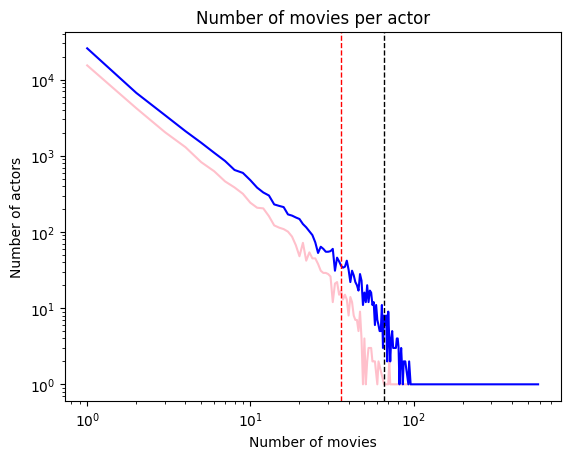

['Bette Davis']
24


In [177]:
working_data_f_movies = working_data_f.groupby('nb_movies').size()
working_data_m_movies = working_data_m.groupby('nb_movies').size()

# Plot number of movies distribution per gender
plt.plot(working_data_f_movies.index, working_data_f_movies, label="Women", color='pink')
plt.plot(working_data_m_movies.index, working_data_m_movies, label="Men", color='blue')

# Add vertical line at the mean
plt.axvline(working_data_m_movies.index.values.mean(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(working_data_f_movies.index.values.mean(), color='red', linestyle='dashed', linewidth=1)
plt.title('Number of movies per actor')
plt.xlabel('Number of movies')  
plt.ylabel('Number of actors')
plt.loglog()
plt.legend
plt.show()

# Faire graphe poire avec Y: nb films, pas d'axe X mais 2 poires, une pour homme et une pour femmes, 
# et la largeur de la poire = nb d'acteurs/rices qui ont fait ce nombre de films

# Get actor name based on freebase_actor_ID
print(character_data[character_data.freebase_actor_ID ==\
     working_data_f[working_data_f.nb_movies > 90].freebase_actor_ID.values[0]].actor_name.unique())


# Number of actors who featured in more than 90 movies
print(working_data_m[working_data_m.nb_movies > 90].freebase_actor_ID.count())


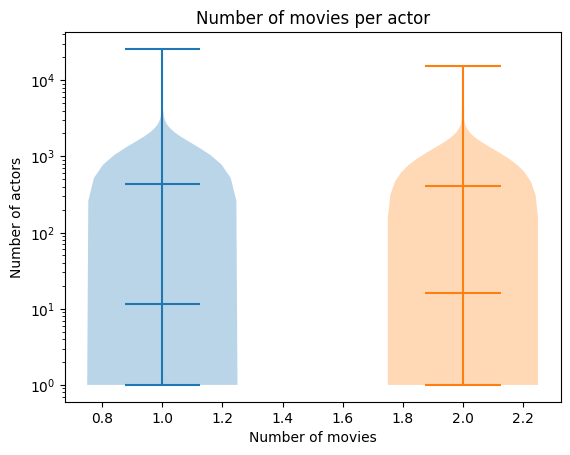

In [236]:
import seaborn as sns

# Violin plot of number of movies per actor
plt.violinplot(working_data_m_movies, positions=[1], showmeans=True, showmedians=True)
plt.violinplot(working_data_f_movies, positions=[2], showmeans=True, showmedians=True)
plt.yscale('log')
plt.title('Number of movies per actor')
plt.xlabel('Number of movies')
plt.ylabel('Number of actors')
plt.show()


# Is the average rating movies different depending on men/women?

Both distribution are bell curves with a mean of 6.1 and a std of 1.05

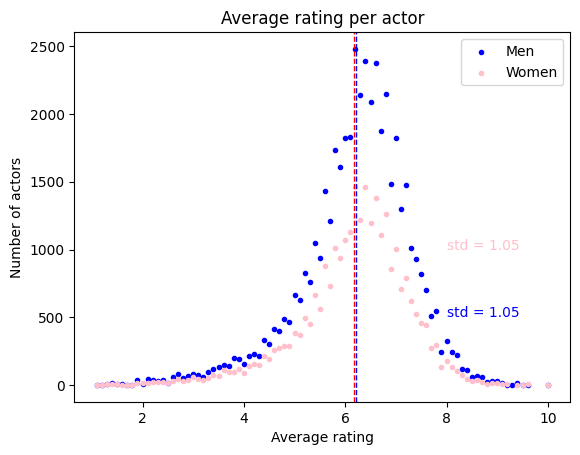

In [228]:
working_data_f_rating = working_data_f.groupby('averageRating').size()
working_data_m_rating = working_data_m.groupby('averageRating').size()

# Compute weighted average
m_avg = np.average(working_data_m_rating.index, weights=working_data_m_rating)
f_avg = np.average(working_data_f_rating.index, weights=working_data_f_rating)
# Compute weighted standard deviation
m_std = np.sqrt(np.average((working_data_m_rating.index - m_avg)**2, weights=working_data_m_rating))
f_std = np.sqrt(np.average((working_data_f_rating.index - f_avg)**2, weights=working_data_f_rating))

plt.scatter(working_data_m_rating.index, working_data_m_rating, color='blue', label = 'Men', marker=".")
plt.scatter(working_data_f_rating.index, working_data_f_rating, color='pink', label = 'Women', marker=".")

# Add vertical line at the mean
plt.axvline(m_avg, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(f_avg, color='red', linestyle='dashed', linewidth=1)
plt.title('Average rating per actor')
plt.xlabel('Average rating')
plt.ylabel('Number of actors')
plt.legend()
plt.show()


# Are movies women feature in more popular vote-wise?

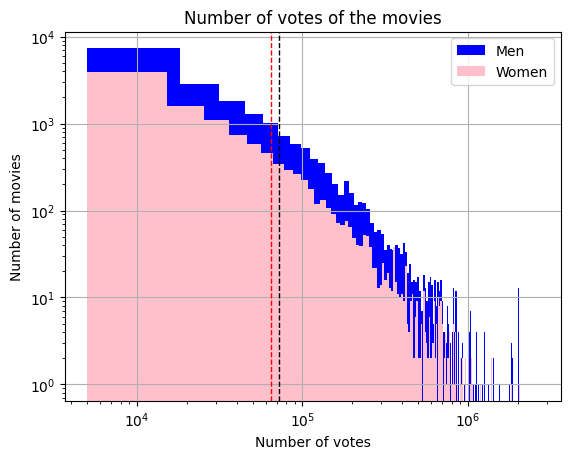

In [226]:
# Keep only the movies with more than 5000 votes
working_data_frating = working_data_f[working_data_f.numVotes > 5000]
working_data_mrating = working_data_m[working_data_m.numVotes > 5000]

# Plot average rating of both working_data_f and working_data_m
working_data_mrating.numVotes.hist(bins=200, label="Men", color='blue')
working_data_frating.numVotes.hist(bins=200, label="Women", color='pink')
# Add vertical line at the mean
plt.axvline(working_data_m['numVotes'].mean(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(working_data_f['numVotes'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.title('Number of votes of the movies')
plt.xlabel('Number of votes')
plt.ylabel('Number of movies')
plt.loglog()
plt.legend()
plt.show()